In [8]:
import pandas as pd

df = pd.read_csv('../data/engineered_retail_data.csv', parse_dates=['Date'])
df = df.sort_values(['product_id', 'Date']).reset_index(drop=True)

# ---- Add extra lag features ----
df['lag_2'] = df.groupby('product_id')['Total_Purchases'].shift(2)
df['lag_3'] = df.groupby('product_id')['Total_Purchases'].shift(3)

# ---- Rolling median ----
df['roll_7_median'] = df.groupby('product_id')['Total_Purchases'].shift(1).rolling(7).median()
df['roll_30_median'] = df.groupby('product_id')['Total_Purchases'].shift(1).rolling(30).median()

# ---- Rolling min/max ----
df['roll_7_min'] = df.groupby('product_id')['Total_Purchases'].shift(1).rolling(7).min()
df['roll_7_max'] = df.groupby('product_id')['Total_Purchases'].shift(1).rolling(7).max()

# ---- EWMA ----
df['ewm_7'] = df.groupby('product_id')['Total_Purchases'].shift(1).ewm(span=7, adjust=False).mean()
df['ewm_30'] = df.groupby('product_id')['Total_Purchases'].shift(1).ewm(span=30, adjust=False).mean()

# Fill missing values created by lags/rolls
df = df.fillna(0)

df.to_csv('../data/engineered_retail_data_catboost_final.csv', index=False)

df.head()


,State,Country,Date,Total_Purchases,Product_Category,Product_Brand,Product_Type,products,product_id,Year,...,roll_30_mean,roll_30_std,lag_2,lag_3,roll_7_median,roll_30_median,roll_7_min,roll_7_max,ewm_7,ewm_30
0,england,united kingdom,2023-03-11,3.0,electronics,sony,television,4k_tv,0,2023,...,6.033333,2.772815,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,new south wales,australia,2023-03-11,4.0,electronics,sony,television,4k_tv,0,2023,...,5.966667,2.797577,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,3.000000
2,georgia,usa,2023-03-11,9.0,electronics,sony,television,4k_tv,0,2023,...,6.166667,2.792642,3.0,0.0,0.0,0.0,0.0,0.0,3.250000,3.064516
3,berlin,germany,2023-03-11,4.0,electronics,samsung,television,4k_tv,0,2023,...,6.233333,2.712466,4.0,3.0,0.0,0.0,0.0,0.0,4.687500,3.447451
4,new south wales,australia,2023-03-11,6.0,electronics,samsung,television,4k_tv,0,2023,...,6.200000,2.708862,9.0,4.0,0.0,0.0,0.0,0.0,4.515625,3.483099


In [9]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

df = pd.read_csv('../data/engineered_retail_data_catboost_final.csv')

# Time-based split
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')



train_df = df[df['Date'] < '2024-01-01']
test_df  = df[df['Date'] >= '2024-01-01']

target = 'Total_Purchases'

# CatBoost can take raw categorical columns
cat_features = ['State','Country','Product_Category','Product_Brand','Product_Type','products']

features = [c for c in df.columns if c not in ['Total_Purchases','Date']]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

model = CatBoostRegressor(
    iterations = 1500,
    depth = 10,
    learning_rate = 0.03,
    loss_function = 'RMSE',
    eval_metric = 'RMSE',
    random_seed = 42,
    task_type = 'CPU',  # change to CPU if no GPU
    early_stopping_rounds = 80
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
    verbose=200
)

pred = model.predict(X_test)

from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    median_absolute_error
)
import numpy as np

# ---- Existing Metrics ----
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

# ---- Additional Metrics ----
# MAPE (avoid divide by zero)
mape = np.mean(np.abs((y_test - pred) / (y_test + 1e-8))) * 100

# SMAPE
smape = 100 * np.mean(
    2 * np.abs(y_test - pred) / (np.abs(y_test) + np.abs(pred) + 1e-8)
)
y_test_clipped  = np.maximum(y_test, 0)
pred_clipped    = np.maximum(pred, 0)
    

# R2 Score
r2 = r2_score(y_test, pred)
# Median Absolute Error
medae = median_absolute_error(y_test, pred)

# RMSLE
rmsle = np.sqrt(mean_squared_error(
    np.log1p(y_test_clipped),
    np.log1p(pred_clipped)
))



# Print all metrics
print("CatBoost Test MAE:", mae)
print("CatBoost Test RMSE:", rmse)
print("CatBoost Test MAPE:", mape)
print("CatBoost Test SMAPE:", smape)
print("CatBoost Test R²:", r2)
print("CatBoost Test Median AE:", medae)
print("CatBoost Test RMSLE:", rmsle)



0:	learn: 2.8358380	test: 2.8466675	best: 2.8466675 (0)	total: 300ms	remaining: 7m 30s
200:	learn: 1.5219837	test: 1.5250364	best: 1.5250364 (200)	total: 59.3s	remaining: 6m 23s
400:	learn: 1.3630764	test: 1.3691596	best: 1.3691596 (400)	total: 1m 59s	remaining: 5m 27s
600:	learn: 1.2949071	test: 1.3071973	best: 1.3071973 (600)	total: 2m 58s	remaining: 4m 26s
800:	learn: 1.2566260	test: 1.2781389	best: 1.2781389 (800)	total: 3m 57s	remaining: 3m 27s
1000:	learn: 1.2283566	test: 1.2612600	best: 1.2612600 (1000)	total: 4m 57s	remaining: 2m 28s
1200:	learn: 1.2045884	test: 1.2507035	best: 1.2507035 (1200)	total: 5m 57s	remaining: 1m 29s
1400:	learn: 1.1835269	test: 1.2431667	best: 1.2431667 (1400)	total: 6m 58s	remaining: 29.6s
1499:	learn: 1.1738281	test: 1.2404471	best: 1.2404471 (1499)	total: 7m 27s	remaining: 0us

bestTest = 1.240447141
bestIteration = 1499

CatBoost Test MAE: 0.985879764940577
CatBoost Test RMSE: 1.2404471405888224
CatBoost Test MAPE: 30.763851307913587
CatBoost Test

In [10]:
pred = model.predict(X_test)


In [11]:
test_df['Predicted'] = pred

daily_actual = test_df.groupby('Date')['Total_Purchases'].sum()
daily_pred = test_df.groupby('Date')['Predicted'].sum()


C:\Users\kasiv\AppData\Local\Temp\ipykernel_2364\3693755839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted'] = pred


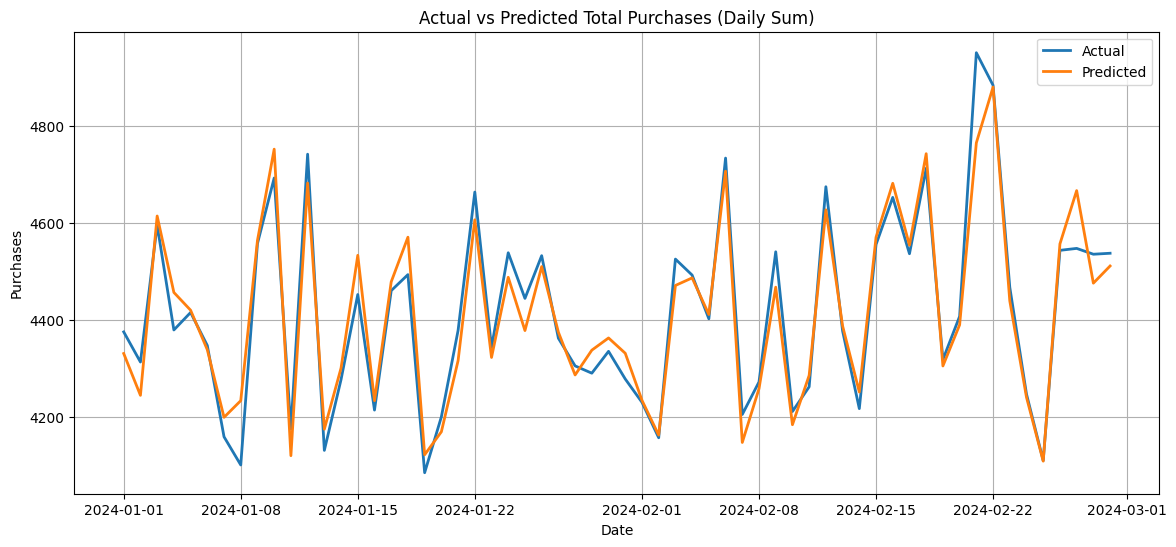

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(daily_actual.index, daily_actual.values, label='Actual', linewidth=2)
plt.plot(daily_pred.index, daily_pred.values, label='Predicted', linewidth=2)
plt.title("Actual vs Predicted Total Purchases (Daily Sum)")
plt.xlabel("Date")
plt.ylabel("Purchases")
plt.legend()
plt.grid(True)
plt.show()
